# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, BatchNormalization, Activation

2025-12-02 22:06:45.275350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 22:06:45.303819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 22:06:50.304122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


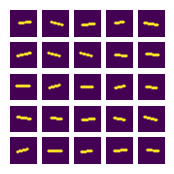

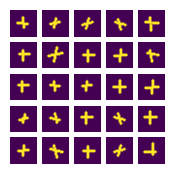

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2694

X_text: "13+47" = y_text: "60 "


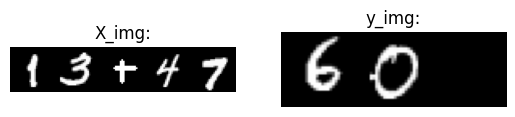

Query #5239

X_text: "26-19" = y_text: "7  "


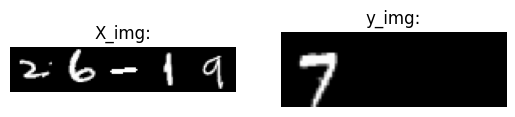

Query #3639

X_text: "18-19" = y_text: "-1 "


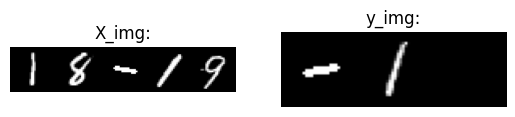

Query #7779

X_text: "38-89" = y_text: "-51"


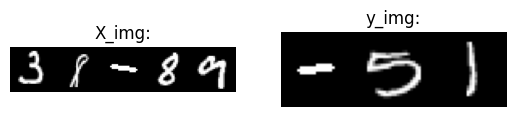

Query #61

X_text: "0-30 " = y_text: "-30"


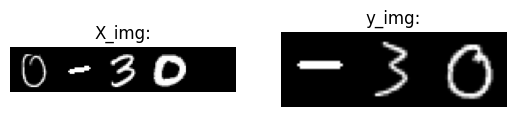

Query #2275

X_text: "11-37" = y_text: "-26"


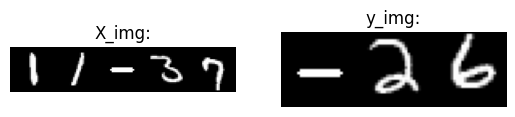

Query #9695

X_text: "48-47" = y_text: "1  "


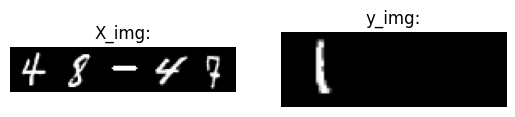

Query #4920

X_text: "24+60" = y_text: "84 "


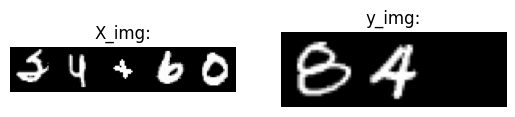

Query #250

X_text: "1+25 " = y_text: "26 "


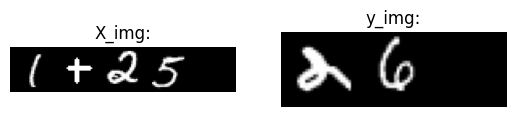

Query #1963

X_text: "9-81 " = y_text: "-72"


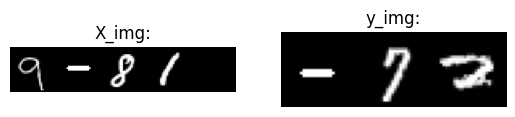

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

# I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    # input_shape=(5, 13)
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

An LSTM input has this shape:
(batch_size, timesteps, features)

timesteps = max_query_length = 5

features = len(unique_characters) = 13

(None, 5, 13)

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)

t2t_model = build_text2text_model()

X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, 
                                                    y_text_onehot,
                                                    test_size= 0.5,
                                                    random_state= 42,
                                                    shuffle= True)

hist_t2t_50 = t2t_model.fit(X_train, 
                        y_train, 
                        epochs=20,
                        validation_data=(X_test, y_test))

acc = hist_t2t_50.history.get("accuracy")[-1] 
val_acc = hist_t2t_50.history.get("val_accuracy")[-1]
val_loss = hist_t2t_50.history.get("val_loss")[-1]

print(f"accuracy {acc}")
print(f"validation accuracy {val_acc}")
print(f"validation loss {val_loss}")

test_loss, test_acc = t2t_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# 5. Inspect some predictions vs ground truth
#    (convert one-hot output back to strings using decode_labels)
idx = np.random.choice(len(X_test), size=10, replace=False)

y_true_strings = decode_labels(y_test[idx])
y_pred_probs   = t2t_model.predict(X_test[idx])
y_pred_strings = decode_labels(y_pred_probs)

for i in range(len(idx)):
    print(f"Query:      {X_text[idx[i]]}")
    print(f"True ans:   '{y_true_strings[i]}'")
    print(f"Predicted:  '{y_pred_strings[i]}'")
    print('-' * 40)


I0000 00:00:1764603613.801120 2259362 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1191 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-12-01 16:40:21.474091: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3648 - loss: 1.8954 - val_accuracy: 0.4154 - val_loss: 1.6146
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4580 - loss: 1.5036 - val_accuracy: 0.4719 - val_loss: 1.4200
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5177 - loss: 1.3285 - val_accuracy: 0.5216 - val_loss: 1.2865
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5591 - loss: 1.2176 - val_accuracy: 0.5679 - val_loss: 1.1679
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5725 - loss: 1.1532 - val_accuracy: 0.5796 - val_loss: 1.1298
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6007 - loss: 1.0883 - val_accuracy: 0.6094 - val_loss: 1.0506
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6074 - loss: 1.0559 - val_accuracy: 0.6191 - val_loss: 1.0242
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6216 - loss: 1.0149 - val_accuracy: 0.6059 - val_


---
---

# II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
# Your code
def build_img2text_model():

    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    # input_shape = (timesteps, features)
    img2text.add(LSTM(256, input_shape=(5, 28*28))) 
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    # img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))


    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text



In [ ]:
# Your code
def build_img2text_model_conv():

    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    # input_shape = (timesteps, features)
    # img2text.add(LSTM(256, input_shape=(5, 28*28))) 
    img2text.add(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        activation='tanh',
        input_shape=(max_query_length, 28, 28, 1),
        return_sequences=False
    ))
    img2text.add(tf.keras.layers.BatchNormalization())

      # Flatten encoder output to pass into dense layers
    img2text.add(Flatten())

    # A Dense layer to compress features into a 256-dimensional vector
    img2text.add(Dense(256, activation='relu'))
    img2text.add(tf.keras.layers.Dropout(0.4))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    # img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))


    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text



In [ ]:
print(X_text[0])
print(X_img[0])

0+0  
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
# X_img shape: (N, 5, 28, 28)
# Reshape to (N, 5, 28*28) for the LSTM
X_img_flat = X_img.reshape(X_img.shape[0], X_img.shape[1], X_img.shape[2]*X_img.shape[3])
print("X_img_flat shape:", X_img_flat.shape)

X_img_flat shape: (20000, 5, 784)


In [ ]:
img2text = build_img2text_model()

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_img_flat,
    y_text_onehot,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

history_i2t = img2text.fit(
    X_train_i, y_train_i,
    validation_data=(X_test_i, y_test_i),
    epochs=20
)

test_loss_i, test_acc_i = img2text.evaluate(X_test_i, y_test_i, verbose=0)
print(f"Flattened [Image→Text] Test loss: {test_loss_i:.4f}, Test accuracy: {test_acc_i:.4f}")

idx = np.random.choice(len(X_test_i), size=10, replace=False)
y_true_strings = decode_labels(y_test_i[idx])
y_pred_probs   = img2text.predict(X_test_i[idx])
y_pred_strings = decode_labels(y_pred_probs)

for i in range(len(idx)):
    print(f"Query images index: {idx[i]}")
    print(f"True ans:   '{y_true_strings[i]}'")
    print(f"Predicted:  '{y_pred_strings[i]}'")
    print('-' * 40)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │     1,065,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,594,637 (6.08 MB)

 Trainable params: 1,594,637 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3571 - loss: 1.9802 - val_accuracy: 0.4003 - val_loss: 1.7818
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4082 - loss: 1.7070 - val_accuracy: 0.4162 - val_loss: 1.6495
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4396 - loss: 1.5871 - val_accuracy: 0.4412 - val_loss: 1.5723
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4578 - loss: 1.5034 - val_accuracy: 0.4494 - val_loss: 1.5330
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4822 - loss: 1.4230 - val_accuracy: 0.4551 - val_loss: 1.5290
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4998 - loss: 1.3599 - val_accuracy: 0.4615 - val_loss: 1.5110
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5188 - loss: 1.3011 - val_accuracy: 0.4704 - val_loss: 1.4865
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5391 - loss: 1.2407 - val_accuracy: 0.

In [ ]:
img2text = build_img2text_model_conv()

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_img,
    y_text_onehot,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

history_i2t = img2text.fit(
    X_train_i, y_train_i,
    validation_data=(X_test_i, y_test_i),
    epochs=20
)

test_loss_i, test_acc_i = img2text.evaluate(X_test_i, y_test_i, verbose=0)
print(f"[Image→Text] Test loss: {test_loss_i:.4f}, Test accuracy: {test_acc_i:.4f}")

# Compare some predictions
idx = np.random.choice(len(X_test_i), size=10, replace=False)
y_true_strings = decode_labels(y_test_i[idx])
y_pred_probs   = img2text.predict(X_test_i[idx])
y_pred_strings = decode_labels(y_pred_probs)

for i in range(len(idx)):
    print(f"Query images index: {idx[i]}")
    print(f"True ans:   '{y_true_strings[i]}'")
    print(f"Predicted:  '{y_pred_strings[i]}'")
    print('-' * 40)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 26, 26, 32)     │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,104,973 (23.29 MB)

 Trainable params: 6,104,909 (23.29 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20


E0000 00:00:1764603684.493652 2259362 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/zeros_switch/_129-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/zeros_switch/_129', 'Func/StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/body/_52/input/_1118' -> 'StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/body/_52/sequential_2_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul'}.


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.3167 - loss: 2.1195 - val_accuracy: 0.3741 - val_loss: 2.1330
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3787 - loss: 1.9321 - val_accuracy: 0.3874 - val_loss: 1.9215
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3942 - loss: 1.8292 - val_accuracy: 0.3898 - val_loss: 1.8327
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4084 - loss: 1.7455 - val_accuracy: 0.3974 - val_loss: 1.8259
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4256 - loss: 1.6752 - val_accuracy: 0.3753 - val_loss: 1.9121
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4415 - loss: 1.6129 - val_accuracy: 0.4012 - val_loss: 1.8019
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4630 - loss: 1.5424 - val_accuracy: 0.3436 - val_loss: 2.1742
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4829 - loss: 1.4793 - val_accuracy: 0.40

---
---

# III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [6]:
# helper funtion for plotting
def display_digits(y_pred, y_true, query_set):
    for i in range(len(y_pred)):
        plt.figure(figsize=(8,4))
        
        for t in range(3):
            # predicted
            plt.subplot(2, 3, t+1)
            plt.imshow(y_pred[i, t], cmap='gray')
            plt.title(f"Pred {t}")
            plt.axis('off')

            # true label
            plt.subplot(2, 3, t+1 + 3)
            plt.imshow(y_true[i, t], cmap='gray')
            plt.title(f"True {t}")
            plt.axis('off')

        plt.suptitle(f"Query: '{query_set[i]}'")
        plt.tight_layout()
        plt.show()

In [7]:
# train and test split
indices = np.arange(len(X_text_onehot))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train_ti = X_text_onehot[train_idx]
X_test_ti  = X_text_onehot[test_idx]
y_train_ti = y_img[train_idx]
y_test_ti  = y_img[test_idx]
y_test_labels_ti = y_text[test_idx]
y_train_labels_ti = y_text[train_idx]

In [8]:
# Model with regular vector-based decoder
def build_text2img_model():
    text2img = tf.keras.Sequential([
        tf.keras.Input(shape=(None, len(unique_characters))),
        LSTM(256),
        RepeatVector(max_answer_length),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(28*28, activation='sigmoid')),
        TimeDistributed(Reshape((28, 28)))
    ])

    text2img.compile(loss='binary_crossentropy', optimizer='adam')
    text2img.summary()

    return text2img

In [9]:
text2img = build_text2img_model()
history_t2i = text2img.fit(X_train_ti, 
                           y_train_ti,
                           validation_split=0.2,
                           epochs=40)

I0000 00:00:1764709616.962388 2623178 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1180 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 784)         │       201,488 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 28, 28)      │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,280 (3.83 MB)

 Trainable params: 1,003,280 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


2025-12-02 22:06:58.286270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2397 - val_loss: 0.2157
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2153 - val_loss: 0.2155
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2152 - val_loss: 0.2153
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2102 - val_loss: 0.2026
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1958 - val_loss: 0.1928
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1903 - val_loss: 0.1886
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1881 - val_loss: 0.1889
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1867 - val_loss: 0.1864
Epoch 9/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1856 - val_loss: 0.1861
Epoch 10/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1848 - val_loss: 0.1843
Epoch 11/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1840 - val_loss: 0.1835
Epoch 12/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


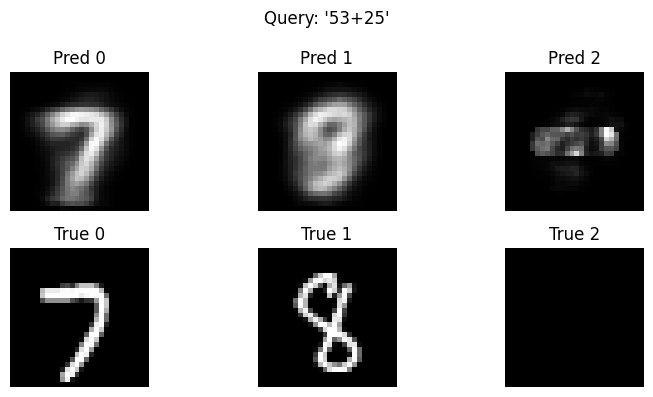

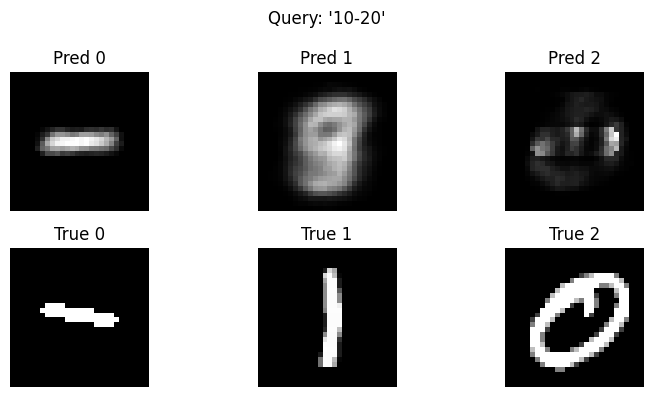

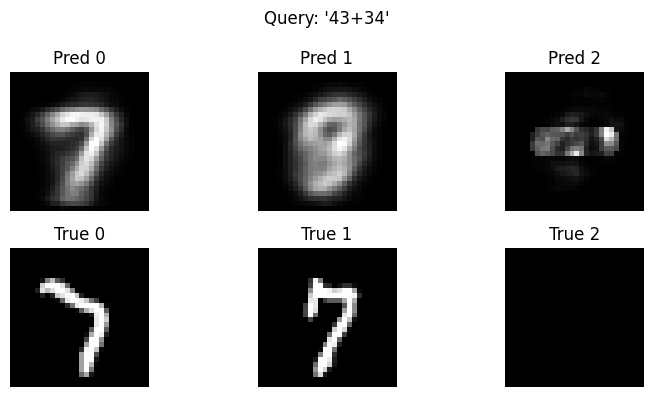

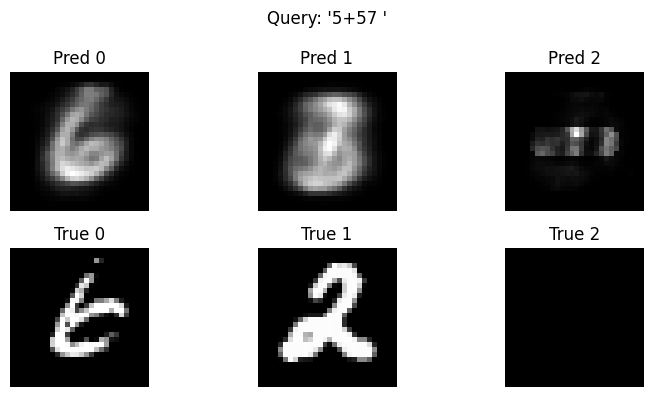

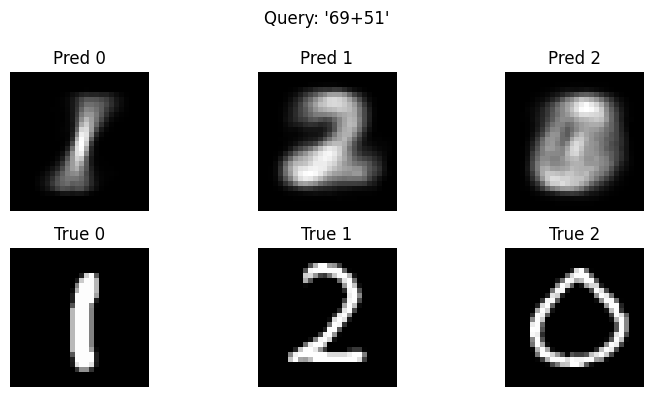

In [10]:
# Predict first 5 test images
y_pred_img_reg = text2img.predict(X_test_ti[:5])
y_true_reg = y_test_ti[:5]
query_set_reg = X_text[test_idx[:5]]

display_digits(y_pred_img_reg, y_true_reg, query_set_reg)

In [ ]:
def build_text2img_model_conv(): 
    text2img_conv = tf.keras.Sequential([
        # encoder
        LSTM(512,input_shape=(None, len(unique_characters))),
        # encoded vector 
        RepeatVector(max_answer_length),
                     
        # decoder 
        LSTM(512, return_sequences=True),
        
        BatchNormalization(), 
                                    
        # transposed convolutions
        # feature expansion 
        TimeDistributed(Dense(7*7*128, use_bias=True)), 
        TimeDistributed(BatchNormalization()),
        Activation(tf.keras.activations.leaky_relu),

        TimeDistributed(Reshape((7, 7, 128))),  
        
        # upsampling 1 -> 7x7 to 14x14
        TimeDistributed(Conv2DTranspose(128, (3,3), strides=2, padding='same', use_bias=True)), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
                                
        
        # convolution layer   
        TimeDistributed(Conv2D(64, (3,3), strides=1, padding='same')), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # upsampling 2 -> 14x14 to 28x28
        TimeDistributed(Conv2DTranspose(32, (3,3), strides=2, padding='same')), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # convolution layer -- output layer
        TimeDistributed(Conv2D(1, (3,3), strides=1, padding='same', activation='sigmoid'))]) 

    text2img_conv.compile(loss='binary_crossentropy', optimizer='adam') 
    text2img_conv.summary() 
    return text2img_conv 

In [ ]:
text2img_conv = build_text2img_model_conv() 
history_t2i_conv = text2img_conv.fit(X_train_ti, 
                                y_train_ti, 
                                validation_split = 0.2, 
                                epochs = 50)

/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 512)            │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 6272)        │     3,217,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 6272)        │        25,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 7, 7, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 14, 14, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 14, 14, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 28, 28, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 28, 28, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,661,889 (25.41 MB)

 Trainable params: 6,648,001 (25.36 MB)

 Non-trainable params: 13,888 (54.25 KB)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2243 - val_loss: 0.2025
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1933 - val_loss: 0.1971
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1898 - val_loss: 0.1925
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1876 - val_loss: 0.1898
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1863 - val_loss: 0.1883
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1848 - val_loss: 0.1863
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1837 - val_loss: 0.1851
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1824 - val_loss: 0.1849
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1821 - val_loss: 0.1849
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1810 - val_loss: 0.1841
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1805 - val_loss: 0.1842
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


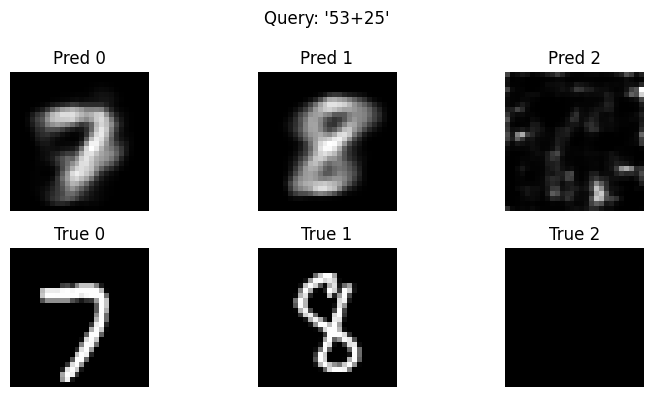

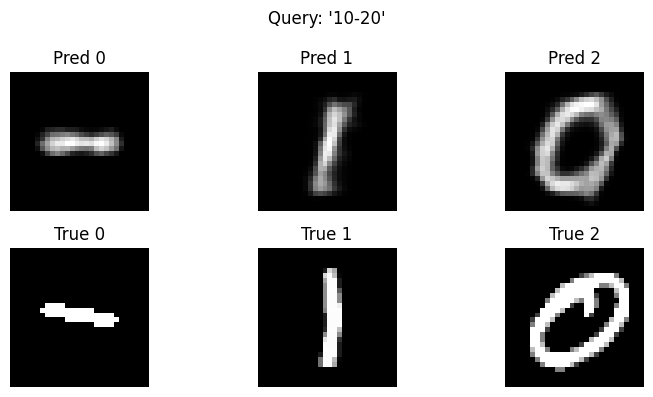

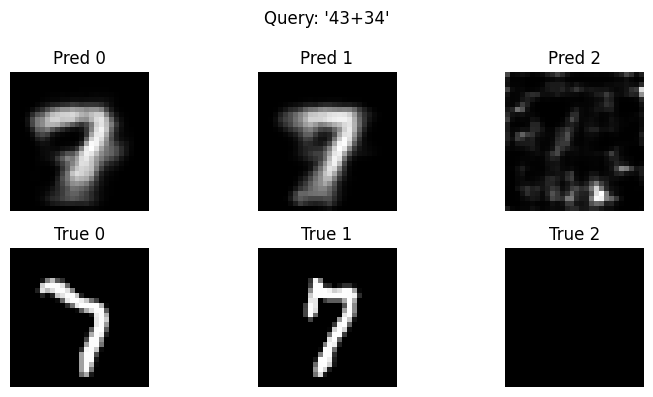

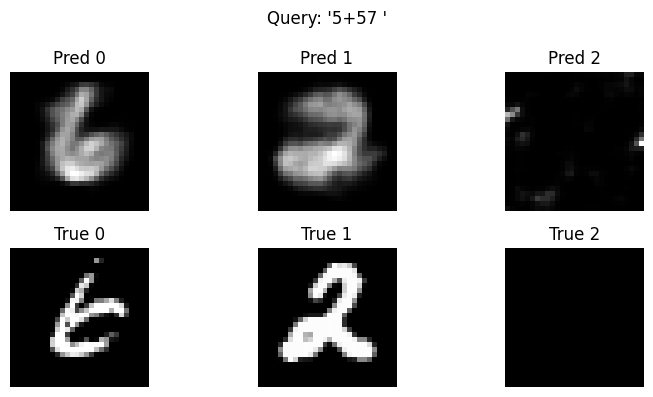

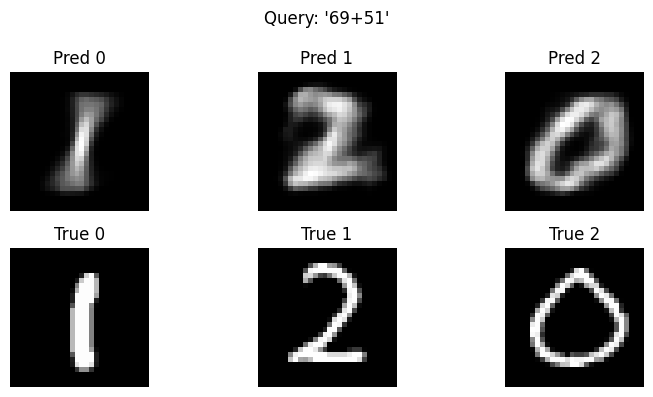

In [13]:
y_pred_img_conv = text2img_conv.predict(X_test_ti[:5])
y_true_conv = y_test_ti[:5]
query_set_conv = X_text[test_idx[:5]]

display_digits(y_pred_img_conv, y_true_conv, query_set_conv)

In [14]:
# cnn classifier for evaluating generated digits
def build_digit_cnn_classifier():
    cnn = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[28, 28, 1]),
        tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        # "0123456789- "
        tf.keras.layers.Dense(12, activation="softmax")
    ])
    cnn.compile(loss="sparse_categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])
    
    return cnn

In [15]:
# separating the text digits --> label of cnn
label_map = {str(d): d for d in range(10)}
label_map['-'] = 10
label_map[' '] = 11

separated_labels_train = []
for s in y_text:
    for char in s:
        separated_labels_train.append(label_map[char])
separated_labels_train = np.array(separated_labels_train)

# separating the image digits --> features of cnn
y_img_separated = y_img.reshape(-1,28,28,1)

# separating the image digits --> to be used with prediction
separated_labels_test = []
for s in y_test_labels_ti:
    for char in s:
        separated_labels_test.append(label_map[char])
separated_labels_test = np.array(separated_labels_test)
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN, = train_test_split(y_img_separated, separated_labels_train, test_size=0.2)

In [16]:
# build and train cnn
cnn_model = build_digit_cnn_classifier()

history = cnn_model.fit(X_train_CNN, 
                        y_train_CNN, 
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20


2025-12-02 22:15:09.491380: I external/local_xla/xla/service/service.cc:163] XLA service 0x7339340274e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 22:15:09.491393: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-02 22:15:09.510812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 22:15:09.689718: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 22:15:09.689778: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of th

  48/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2171 - loss: 2.4128

I0000 00:00:1764710111.856773 2623628 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1198/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7078 - loss: 0.9096

2025-12-02 22:15:15.946365: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 22:15:16.238804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 100 bytes spill stores, 100 bytes spill loads



1200/1200 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8477 - loss: 0.4874 - val_accuracy: 0.9792 - val_loss: 0.0850
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9570 - loss: 0.1578 - val_accuracy: 0.9881 - val_loss: 0.0491
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9683 - loss: 0.1182 - val_accuracy: 0.9883 - val_loss: 0.0468
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9776 - loss: 0.0840 - val_accuracy: 0.9905 - val_loss: 0.0578
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9800 - loss: 0.0768 - val_accuracy: 0.9918 - val_loss: 0.0443
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9829 - loss: 0.0607 - val_accuracy: 0.9910 - val_loss: 0.0460
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9853 - loss: 0.0528 - val_accuracy: 0.9917 - val_loss: 0.0605
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9860 - loss: 0.0529 - val_accurac

In [17]:
# prediction == generation
y_pred_img_reg = text2img.predict(X_test_ti)

# separating predicted digits
generated_images_reg = y_pred_img_reg.reshape(-1, 28, 28, 1)

# cnn prediction
digit_preds_reg = cnn_model.predict(generated_images_reg)
digit_preds_reg = np.argmax(digit_preds_reg, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step


In [18]:
# prediction == generation
y_pred_img_conv = text2img_conv.predict(X_test_ti)

# separating predicted digits
generated_images_conv = y_pred_img_conv.reshape(-1, 28, 28, 1)
# cnn prediction
digit_preds_conv = cnn_model.predict(generated_images_conv)
digit_preds_conv = np.argmax(digit_preds_conv, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
report_reg = classification_report(separated_labels_test, digit_preds_reg)
report_conv = classification_report(separated_labels_test, digit_preds_conv)
print("Classification Report for Dense Decoder:")
print(report_reg)
print("Classification Report for ConvTranspose Decoder:")
print(report_conv)

Classification Report for Dense Decoder:
              precision    recall  f1-score   support

           0       1.00      0.19      0.33       597
           1       0.00      0.00      0.00      1991
           2       0.00      0.00      0.00       926
           3       0.00      0.00      0.00       827
           4       0.00      0.00      0.00       860
           5       0.00      0.00      0.00       718
           6       0.00      0.00      0.00       750
           7       0.00      0.00      0.00       707
           8       0.00      0.00      0.00       618
           9       0.00      0.00      0.00       596
          10       1.00      0.98      0.99      1014
          11       0.22      1.00      0.36      2396

    accuracy                           0.29     12000
   macro avg       0.18      0.18      0.14     12000
weighted avg       0.18      0.29      0.17     12000

Classification Report for ConvTranspose Decoder:
              precision    recall  f1-score

/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

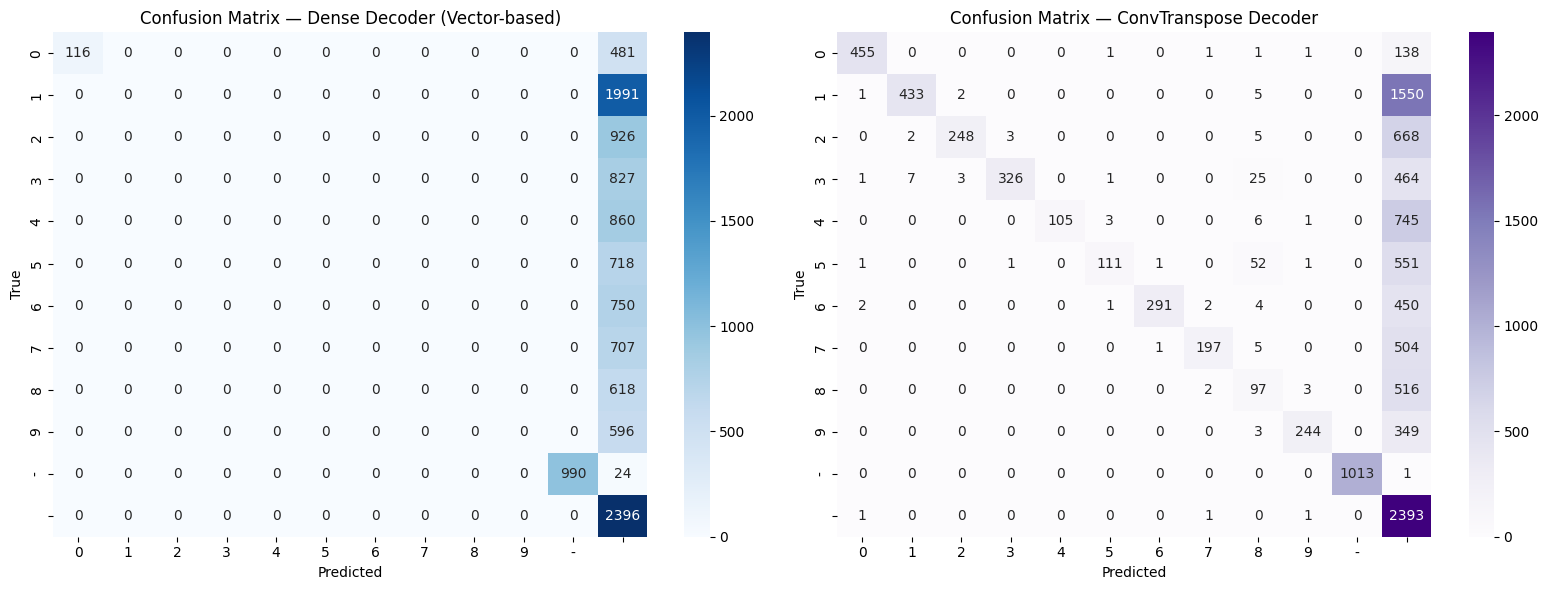

In [20]:
import seaborn as sns
# Compute confusion matrices
cm_reg  = confusion_matrix(separated_labels_test, digit_preds_reg)
cm_conv = confusion_matrix(separated_labels_test, digit_preds_conv)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

labels = [str(i) for i in range(10)] + ['-', ' ']

# --- Model 1: Dense decoder ---
sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Confusion Matrix — Dense Decoder (Vector-based)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# --- Model 2: ConvTranspose decoder ---
sns.heatmap(cm_conv, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Confusion Matrix — ConvTranspose Decoder")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

---
---

# IV. Additional LSTM layers

Try adding additional LSTM layers to your encoder networks and see how the performance of your
 models changes. Try to explain these performance differences in the context of the mistakes that
 your network was making before. Tip: you should add a flag ”return sequences=True” to the first
 recurrent layer of your network.

## III.Text to Image Model Extended

In [60]:
def build_text2img_model_conv_extended(): 
    text2img_conv = tf.keras.Sequential([
        # encoder
        # in - (batch, 5, 13)
        # out - (batch, 5, 512)
        LSTM(512,input_shape=(None, len(unique_characters)), return_sequences=True),
        # in - (batch, 5, 512)
        # out - (batch, 512)
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        LSTM(512),
        
        # encoded vector 
        RepeatVector(max_answer_length),
                     
        # decoder 
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        
        BatchNormalization(), 
                                        
        # transposed convolutions
        # feature expansion 
        TimeDistributed(Dense(7*7*128, use_bias=True)), 
        TimeDistributed(BatchNormalization()),
        Activation(tf.keras.activations.leaky_relu),

        TimeDistributed(Reshape((7, 7, 128))),  
        
        # upsampling 1 -> 7x7 to 14x14
        TimeDistributed(Conv2DTranspose(128, (3,3), strides=2, padding='same', use_bias=True)), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
                                
        
        # convolution layer   
        TimeDistributed(Conv2D(64, (3,3), strides=1, padding='same')), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # upsampling 2 -> 14x14 to 28x28
        TimeDistributed(Conv2DTranspose(32, (3,3), strides=2, padding='same')), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # convolution layer -- output layer
        TimeDistributed(Conv2D(1, (3,3), strides=1, padding='same', activation='sigmoid'))]) 

    text2img_conv.compile(loss='binary_crossentropy', optimizer='adam') 
    text2img_conv.summary() 
    return text2img_conv 

In [61]:
text2img_conv_extended = build_text2img_model_conv_extended()

/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                  │ (None, None, 512)      │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, None, 512)      │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, None, 512)      │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_74             │ (None, 3, 6272)        │     3,217,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_75             │ (None, 3, 6272)        │        25,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_76             │ (None, 3, 7, 7, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_77             │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_78             │ (None, 3, 14, 14, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_79             │ (None, 3, 14, 14, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 3, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_80             │ (None, 3, 28, 28, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_81             │ (None, 3, 28, 28, 32)  │           12

 Total params: 19,257,089 (73.46 MB)

 Trainable params: 19,243,201 (73.41 MB)

 Non-trainable params: 13,888 (54.25 KB)

In [ ]:
text2img_conv_extended = build_text2img_model_conv() 
history_t2i_conv_extended = text2img_conv_extended.fit(X_train_ti, 
                                y_train_ti, 
                                validation_split = 0.2, 
                                epochs = 50)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 512)            │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_83             │ (None, 3, 6272)        │     3,217,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_84             │ (None, 3, 6272)        │        25,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_85             │ (None, 3, 7, 7, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_86             │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_87             │ (None, 3, 14, 14, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_88             │ (None, 3, 14, 14, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 3, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_89             │ (None, 3, 28, 28, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_90             │ (None, 3, 28, 28, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 3, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_91             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,661,889 (25.41 MB)

 Trainable params: 6,648,001 (25.36 MB)

 Non-trainable params: 13,888 (54.25 KB)

Epoch 1/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


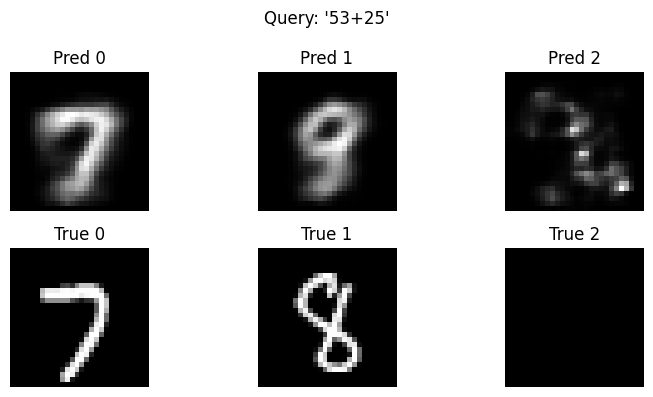

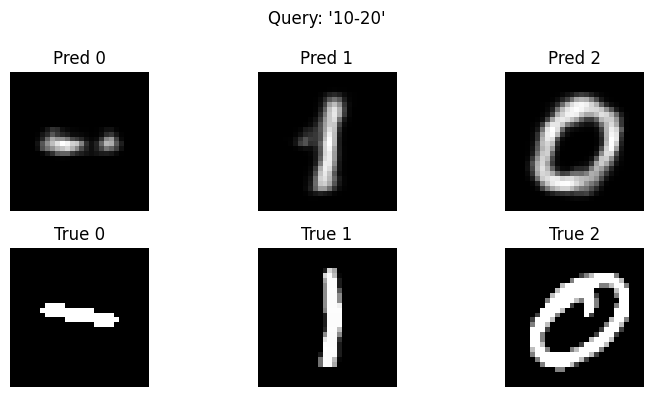

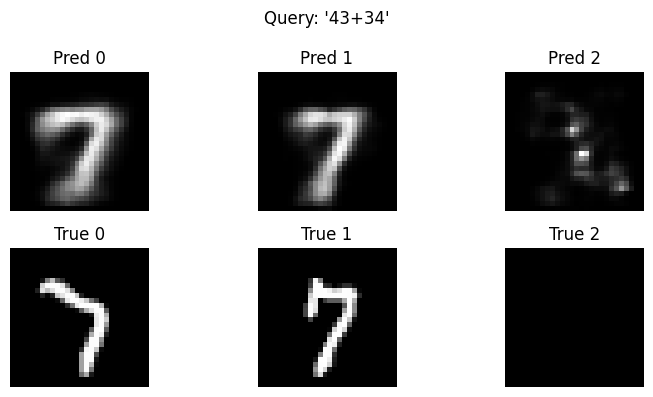

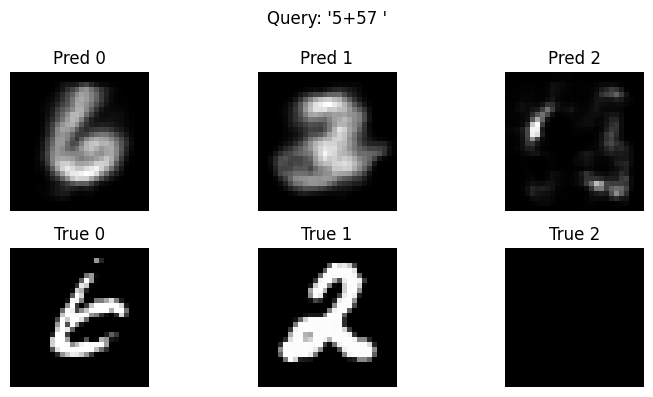

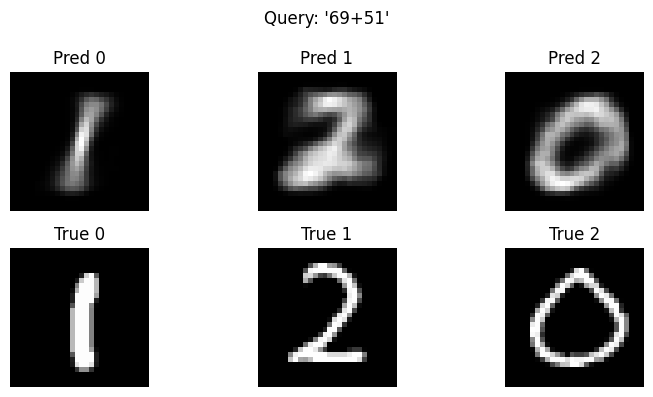

In [ ]:
y_pred_img_conv_extended = text2img_conv_extended.predict(X_test_ti[:5])
y_true_conv_extended = y_test_ti[:5]
query_set_conv_extended = X_text[test_idx[:5]]

display_digits(y_pred_img_conv_extended, y_true_conv_extended, query_set_conv_extended)

In [ ]:
# prediction == generation
y_pred_img_conv_extended = text2img_conv_extended.predict(X_test_ti)

# separating predicted digits
generated_images_conv_extended = y_pred_img_conv_extended.reshape(-1, 28, 28, 1)

# cnn prediction
digit_preds_conv_extended = cnn_model.predict(generated_images_conv_extended)
digit_preds_conv_extended = np.argmax(digit_preds_conv_extended, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


In [ ]:
report_conv_extended = classification_report(separated_labels_test, digit_preds_conv_extended)
print("Classification Report for Extended ConvTranspose Decoder:")
print(report_conv_extended)

Classification Report for Extended ConvTranspose Decoder:
              precision    recall  f1-score   support

           0       0.93      0.40      0.56       597
           1       0.94      0.11      0.20      1991
           2       0.96      0.12      0.22       926
           3       0.97      0.13      0.23       827
           4       1.00      0.00      0.01       860
           5       1.00      0.04      0.07       718
           6       0.99      0.24      0.39       750
           7       0.96      0.15      0.26       707
           8       0.48      0.05      0.09       618
           9       0.94      0.12      0.22       596
          10       1.00      0.96      0.98      1014
          11       0.24      1.00      0.39      2396

    accuracy                           0.37     12000
   macro avg       0.87      0.28      0.30     12000
weighted avg       0.80      0.37      0.31     12000

